In [98]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
credentials = service_account.Credentials.from_service_account_file(
    'path_to_apikey')
project_id = 'project_id'

In [ ]:
query = '''
--для каждого юзера находим минимальную дату старта сессии
WITH table_1 AS (
SELECT
  MIN(event_date) AS firstMonthTransaction,
  user_pseudo_id AS id
FROM `table`
WHERE (_TABLE_SUFFIX between '20190101' AND '20190931') 
   AND event_name = 'session_start'
GROUP BY user_pseudo_id),


-- для каждой даты считаем сколько раз каждый юзер зашел в приложение


table_2 AS (
SELECT
  event_date AS date,
  user_pseudo_id AS id,
  COUNT(*) AS count_users
FROM `table`
WHERE (_TABLE_SUFFIX between '20190101' AND '20190931') 
   AND event_name = 'session_start'
GROUP BY user_pseudo_id, event_date ),


table_join AS(
SELECT
   SUBSTR(table_1.firstMonthTransaction, 1, 6) AS firstMonthTransaction,
   SUBSTR(table_2.date, 1, 6) AS monthTransaction,
   table_2.id AS id,
   SUM(table_2.count_users) AS transactions
FROM
    table_1
  LEFT JOIN
    table_2
  ON
    table_1.id = table_2.id
GROUP BY
  firstMonthTransaction,
  monthTransaction,
  id)

--берем из результирующей таблицы айди и нарезаем на месяцы, считая количество вернвшихся уников в каждом месяце

SELECT
  firstMonthTransaction as cohort_month,
  monthTransaction as return_month, COUNT(DISTINCT id) as count_unique_users
FROM
  table_join
GROUP BY monthTransaction, firstMonthTransaction
'''

In [99]:
retention = pd.read_gbq(query, project_id=project_id, credentials=credentials, dialect='standard')

In [142]:
retention['monthTransaction'] = retention['monthTransaction'].astype('int')
retention['cohort_month'] = retention['cohort_month'].astype('int')

In [198]:
def print_separate_graph_for_all_cohorts(df):
    '''
    Печатает отдельные графики retention для каждой когорты с абсолютными цифрами по уникальным пользователям
    '''
    month_df = [i for i in retention.cohort_month.unique()]
    for month in month_df:
        temp = retention[retention['cohort_month'] == month][['monthTransaction','count_users']]\
        .sort_values('monthTransaction').set_index('monthTransaction')
        ax = temp.plot(grid=True)
        ax.set(ylabel='Количество уникальных юзеров', xlabel='Месяц', title = f'Retention для когорты месяца: {str(month)[4:]}' )
        temp2 = temp.sort_values('monthTransaction', ascending=False)
        ax2 = temp2.plot(kind='barh')
        ax2.set(ylabel='Месяц', xlabel='Количество уникальных юзеров', title = f'Retention для когорты месяца: {str(month)[4:]} (в другом виде)' )
        print('     ====================================================================================')
        plt.show()

In [178]:
# считаем номер месяца внутри одной когорты
def cohort_period(df):
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

In [183]:
#группируем исходные датафрейм, внутри дф нумеруем cohort_period
cohorts = retention.sort_values(['cohort_month','monthTransaction'])\
            .groupby('cohort_month')\
            .apply(cohort_period)

,cohort_month,monthTransaction,count_users,CohortPeriod
35,201901,201901,641629,1
34,201901,201902,326821,2
37,201901,201903,284594,3
39,201901,201904,255458,4
38,201901,201905,243822,5
36,201901,201906,221299,6
40,201901,201907,200533,7
33,201901,201908,189249,8
41,201901,201909,59836,9
25,201902,201902,300837,1


In [187]:
# перевожу в мультииндекс месяц когорты и период
cohorts.set_index(['cohort_month', 'CohortPeriod'], inplace=True)

In [190]:
#проверяем размер когорт
cohort_group_size = cohorts['count_users'].groupby(level=0).first()
cohort_group_size

cohort_month
201901    641629
201902    300837
201903    270074
201904    246982
201905    231292
201906    220135
201907    237007
201908    228853
Name: count_users, dtype: int64

In [203]:
#абсолютные цифры
user_retention_absolute = cohorts['count_users'].unstack(0)
user_retention_absolute

cohort_month,201901,201902,201903,201904,201905,201906,201907,201908
CohortPeriod,,,,,,,,
1,641629.0,300837.0,270074.0,246982.0,231292.0,220135.0,237007.0,228853.0
2,326821.0,121990.0,103985.0,101095.0,89837.0,85124.0,91460.0,33848.0
3,284594.0,95755.0,84007.0,75524.0,66187.0,62769.0,20820.0,NaN
4,255458.0,88538.0,71301.0,62990.0,56734.0,16281.0,NaN,NaN
5,243822.0,78647.0,62009.0,56635.0,14863.0,NaN,NaN,NaN
6,221299.0,70426.0,57380.0,14854.0,NaN,NaN,NaN,NaN
7,200533.0,65724.0,15297.0,NaN,NaN,NaN,NaN,NaN
8,189249.0,17264.0,NaN,NaN,NaN,NaN,NaN,NaN
9,59836.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [204]:
#проценты в когорте, от количества юзеров в первый месяц
user_retention_percent = cohorts['count_users'].unstack(0).divide(cohort_group_size, axis=1)
user_retention

cohort_month,201901,201902,201903,201904,201905,201906,201907,201908
CohortPeriod,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,0.509361,0.405502,0.385024,0.409321,0.388414,0.386690,0.385896,0.147903
3,0.443549,0.318295,0.311052,0.305787,0.286162,0.285139,0.087846,NaN
4,0.398140,0.294306,0.264005,0.255039,0.245292,0.073959,NaN,NaN
5,0.380005,0.261427,0.229600,0.229308,0.064261,NaN,NaN,NaN
6,0.344902,0.234100,0.212460,0.060142,NaN,NaN,NaN,NaN
7,0.312537,0.218470,0.056640,NaN,NaN,NaN,NaN,NaN
8,0.294951,0.057387,NaN,NaN,NaN,NaN,NaN,NaN
9,0.093256,NaN,NaN,NaN,NaN,NaN,NaN,NaN


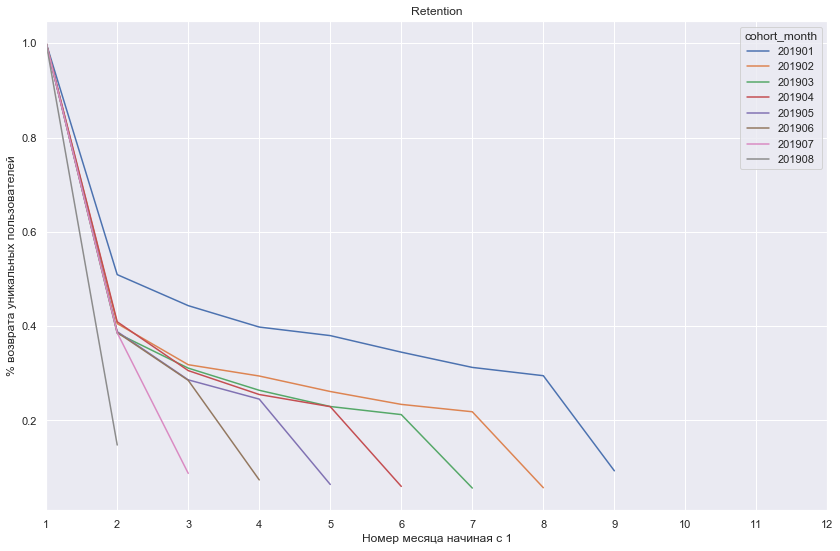

In [219]:
user_retention_percent[list(cohorts.reset_index().cohort_month.unique())].plot(figsize=(14,9))
plt.title('Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% возврата уникальных пользователей')
plt.xlabel('Номер месяца начиная с 1')
plt.show()

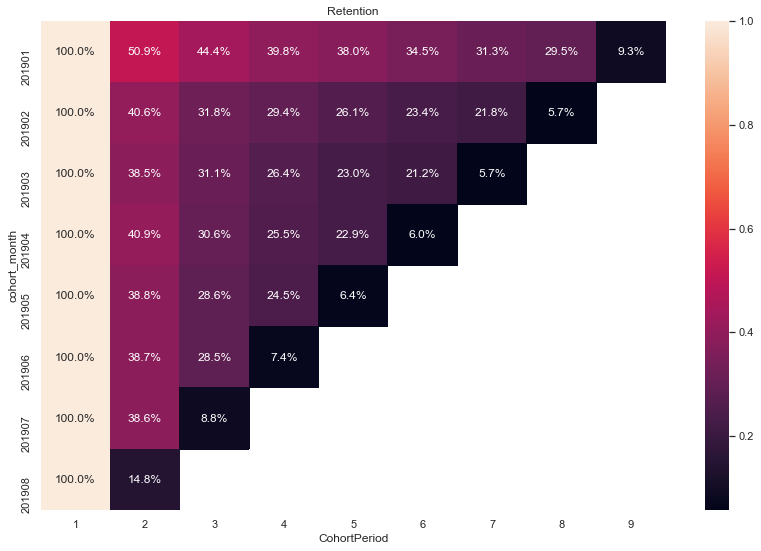

In [230]:
sns.set(style='white')
plt.figure(figsize=(14, 9))
plt.title('Retention')
sns.heatmap(user_retention_percent.T, mask=user_retention.T.isnull(), annot=True, fmt='.1%');